# 特斯拉ptt輿情分析

## 動機和分析目的
利用ptt對特斯拉的文章，進行以下的分析，可能的分析方向如下：
+ 社群媒體分析：探索特斯拉在不同社群媒體平台上的評論和討論。如特斯拉的技術創新、環保意識等。
+ 市場趨勢預測：分析特斯拉的新產品發布、重大事件或競爭對手的動態對市場的影響，並進行股市趨勢預測。
+ 產品品質分析：使分析消費者的投訴、讚美和建議，並進行情緒分類和主題分析，探討產品品質的缺點與優點。
+ 競爭分析：分析特斯拉與其他競爭對手的比較。特斯拉和其他汽車品牌的情緒和評價，了解特斯拉市場上的定位和競爭策略。

In [70]:
import time 
import pandas as pd #pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
import numpy as np #numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
import re #re: 正規表達式套件。
import math #math: 數學運算工具。
import datetime
from pprint import pprint
from collections import defaultdict
import multiprocessing
import os
from getpass import getpass
import seaborn as sns
from matplotlib import font_manager
import matplotlib.pyplot as plt  #matplotlib: 繪圖工具。
import matplotlib.font_manager as fm
import jieba #jieba: 中文斷詞套件。
import jieba.analyse
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker 
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import font_manager
from nltk import ngrams, FreqDist #NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
from collections import Counter, namedtuple #collections: 提供額外的數據類型。
import networkx as nx #networkx: 網絡圖建構、繪製工具。
from snownlp import SnowNLP #SnowNLP 針對中文設計，可以提取句子的情緒分類
# from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer #CountVectorizer, TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
import guidedlda
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER

## 資料集
資料來源：
+ 資料來源：tarflow PPT車版
+ 關鍵字：特斯拉、Tesla
+ 停用字：馬司克、Musk 
+ 資料筆數：1585篇
+ 訓練資料日期：2023/1/1 - 2024/04/30

## 標注文章
三種方式 : guilda、bert_Topic、prompt engineering

### 載入HuggingfaceAPI

In [ ]:
HUGGINGFACEHUB_API_TOKEN = getpass()
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HUGGINGFACEHUB_API_TOKEN

### 使用HuggingFaceEndPoint with google/gemma-1.1-7b-it

In [ ]:
llm = HuggingFaceEndpoint(
    repo_id="google/gemma-1.1-7b-it", temperature=1.0,model_kwargs={'token':HUGGINGFACEHUB_API_TOKEN, 'use_cache':False}
)

/opt/anaconda3/envs/python38/lib/python3.8/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFaceEndpoint` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the from langchain-huggingface package and should be used instead. To use it run `pip install -U from langchain-huggingface` and import as `from from langchain_huggingface import llms import HuggingFaceEndpoint`.
  warn_deprecated(


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/aiden/.cache/huggingface/token
Login successful


In [ ]:
MetaData.head()

,artDate,artTitle,artContent,sentence
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎
1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...
2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...
3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...
4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...


### 產生prompt模板

In [ ]:
class ArticleClassification(BaseModel):
    文章分類: str = Field(..., description="分類此文章的主題。", enum=["服務方面", "車輛交付方面", "性價比方面", "安全性方面", "使用者體驗"])
    情緒: str = Field(..., description="判斷整篇文章的總體情緒。", enum=["正向", "中性", "負向"])

article_parser = JsonOutputParser(pydantic_object=ArticleClassification)

In [ ]:
# Few-shot Template
fewshot_template = """<start_of_turn>user
你是一個強大的語言模型，能夠根據給定的文本進行分類。
請抓取每一篇文章，進行分類與情緒分類。

1.評論此文章的情緒，正向或負向或中性
2.分類此文章，共有a-e共種分類，請將文章進行分類
    a. 服務方面：特斯拉售前、售後整體過程之服務。
    b. 車輛交付方面：從下訂單到車輛交付的方面。
    c. 性價比方面：衡量特斯拉價格與其所能提供的能力
    d. 安全性方面：特斯拉的主動和被動安全措施、電池安全、充電安全以及整車安全設計等多個方面。
    e. 使用者體驗：從車輛的駕駛感受、操作界面、智慧化功能到軟硬體支援等多個面向的體驗。

以下為一些範例
```
範例1
句子：這款電動車雖然價格不便宜，但確實是物有所值
抓取結果：{{
    "文章分類":"性價比方面",
    "情緒":"正面",
}}

範例2
句子：特斯拉的客服服務真的很友善，幫助我解決了很多問題
抓取結果：{{
    "文章分類":"服務方面",
    "情緒":"正面",
}}

範例3
句子：我最近買了特斯拉的 Model 3，車輛交付的速度真的很快
抓取結果：{{
    "文章分類":"車輛交付方面",
    "情緒":"正面",
}}

範例4
句子：相同的電動車，特斯拉的蓄電量較低然後又比較貴
抓取結果：{{
    "文章分類":"性價比方面",
    "情緒":"負面",
}}

範例5
句子：我最近發生了一次車禍，幸好特斯拉的安全措施幫助我避免了更嚴重的損害
抓取結果：{{
    "文章分類":"安全性方面",
    "情緒":"正面",
}}

範例6
句子：特斯拉的操作界面真的很友善，讓我很容易上手
抓取結果：{{
    "文章分類":"使用者體驗",
    "情緒":"正面",
}}

範例7
句子：特斯拉的客服服務真的很慢，需要等很久才能解決問題
抓取結果：{{
    "文章分類":"服務方面",
    "情緒":"負面",
}}

範例8
句子：我最近買了特斯拉的 Model S，車輛交付的速度真的很慢
抓取結果：{{
    "文章分類":"車輛交付方面",
    "情緒":"負面",
}}

範例9
句子：特斯拉的價格真的很高，沒有太多的選擇
抓取結果：{{
    "文章分類":"性價比方面",
    "情緒":"負面",
}}

範例10
句子：特斯拉的安全措施真的很好，讓我感到很安全
抓取結果：{{
    "文章分類":"安全性方面",
    "情緒":"正面",
}}

範例11
句子：特斯拉的操作界面真的很複雜，需要花很多時間學習
抓取結果：{{
    "文章分類":"使用者體驗",
    "情緒":"負面",
}}

範例12
句子：特斯拉的車子失控，我無法正常駕駛他
抓取結果：{{
    "文章分類":"安全性方面",
    "情緒":"負面",
}}


{format_instructions}
請使用繁體中文回答。
除了 JSON 內容外，不要回答任何其他內容

現在請回答以下問題：
文本：{text}
抓取結果：<end_of_turn>
<start_of_turn>model
"""


article_prompt = PromptTemplate(
    template=fewshot_template,
    input_variables=["text"],
    partial_variables={"format_instructions": article_parser.get_format_instructions()},
)

chain = article_prompt | llm


### 定義函式：萃取LLMs回答的結果

In [ ]:
import json

# 從 json 字串中抓取答案
def extract_answer_from_string(string_):
    string_ = string_.replace("\n", "")
    string_ = string_.replace("json", "")
    string_ = string_.replace("    ", "")
    string_ = string_.replace("```", "")
    try:
        dict_result = json.loads(string_)
    except:
        print(string_)
        return string_
    return dict_result

# 從 dict 抓取情緒
def get_sentiment(row):
    try:
        # 去除多餘的空格和換行符號
        cleaned_row = row.replace(' ', '').replace('\n', '').replace('\r', '')
        # 確保最後一個符號不是逗號
        if cleaned_row.endswith(',}'):
            cleaned_row = cleaned_row.replace(',}', '}')
        data = json.loads(cleaned_row)
        return data.get('情緒', None)
    except (json.JSONDecodeError, TypeError, AttributeError):
        return None

# 從 dict 抓取文章分類
def get_classification(row):
    try:
        # 去除多餘的空格和換行符號
        cleaned_row = row.replace(' ', '').replace('\n', '').replace('\r', '')
        # 確保最後一個符號不是逗號
        if cleaned_row.endswith(',}'):
            cleaned_row = cleaned_row.replace(',}', '}')
        data = json.loads(cleaned_row)
        return data.get('文章分類', None)
    except (json.JSONDecodeError, TypeError, AttributeError):
        return None

### 將原始資料拆分12份，進丟進LLMs運行

In [ ]:
# 將MetaData拆分成12份
split_dfs = np.array_split(MetaData, 12)

# 定義一個函數來處理每個分割的資料
def process_split_df(split_df, index):
    split_df['LLM'] = split_df['artContent'].apply(lambda x: extract_answer_from_string(chain.invoke({"text": x})))
    split_df['sentiment'] = split_df['LLM'].apply(get_sentiment)
    split_df['class'] = split_df['LLM'].apply(get_classification)
    split_df.to_csv(f'./data/ppt_tesla_classified_part_{index}.csv', index=False, encoding='UTF-8')

# 逐個處理每個分割的資料
for i in range(0, 12):
    print(f"Processing part {i}")
    process_split_df(split_dfs[i], i)

### 將12份運行結果合併

In [ ]:
# 讀取所有 CSV 檔案並合併為一個 DataFrame
llms_class = pd.concat([
    pd.read_csv('./data/ppt_tesla_classified_part_0.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_1.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_2.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_3.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_4.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_5.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_6.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_7.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_8.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_9.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_10.csv', encoding='UTF-8'),
    pd.read_csv('./data/ppt_tesla_classified_part_11.csv', encoding='UTF-8')
], ignore_index=True)

# 重設 index 並將新的 index 命名為 'system_id'
llms_class = llms_class.reset_index().rename(columns={'index': 'system_id'})
llms_class = llms_class.rename(columns={'情緒': 'sentiment'})
llms_class = llms_class.rename(columns={'文章分類': 'class'})
# 顯示更新後的 DataFrame
llms_class

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",NaN,NaN
1,1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,"{""文章分類"":""性價比方面"",""情緒"":""負面"",}",NaN,NaN
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",NaN,NaN
3,3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"{""文章分類"":""使用者體驗"",""情緒"":""負面"",}",NaN,NaN
4,4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",NaN,NaN
...,...,...,...,...,...,...,...,...
1580,1580,2024-04-30 10:33:35,新聞特斯拉全新入門電動車準備量產,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",NaN,NaN
1581,1581,2024-04-30 12:24:31,分享撞緩撞車啦,要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...,要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...,"{""文章分類"": ""政策與法規方面"",""情緒"": ""正面"",""內容"": ""要系統性的改善緩撞...",NaN,NaN
1582,1582,2024-04-30 17:45:19,新聞銷售降溫賓士上季獲利銳減逾三成福斯,都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...,都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...,"{""文章分類"": ""使用者體驗"",""情緒"": ""正面""}",NaN,NaN
1583,1583,2024-04-30 19:19:58,問題,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",NaN,NaN


### 提取LLMs回答的內容，產生「文章分類」、「文章情緒」兩個標籤

In [ ]:
llms_class['sentiment'] = llms_class['LLM'].apply(get_sentiment)
llms_class['class'] = llms_class['LLM'].apply(get_classification)

# 儲存清理後的結果，只保留指定欄位
llms_class.to_csv('./data/ppt_tesla_classified_cleaned.csv', index=False, encoding='UTF-8')
llms_class

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面
1,1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,"{""文章分類"":""性價比方面"",""情緒"":""負面"",}",負面,性價比方面
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗
3,3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"{""文章分類"":""使用者體驗"",""情緒"":""負面"",}",負面,使用者體驗
4,4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面
...,...,...,...,...,...,...,...,...
1580,1580,2024-04-30 10:33:35,新聞特斯拉全新入門電動車準備量產,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面
1581,1581,2024-04-30 12:24:31,分享撞緩撞車啦,要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...,要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...,"{""文章分類"": ""政策與法規方面"",""情緒"": ""正面"",""內容"": ""要系統性的改善緩撞...",正面,政策與法規方面
1582,1582,2024-04-30 17:45:19,新聞銷售降溫賓士上季獲利銳減逾三成福斯,都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...,都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...,"{""文章分類"": ""使用者體驗"",""情緒"": ""正面""}",正面,使用者體驗
1583,1583,2024-04-30 19:19:58,問題,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面


## 情緒分析

###  1. Guild LDA

In [71]:
FontPath = 'data/SourceHanSansTW-Regular.otf' # 設定字型
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
plt.rcParams['axes.unicode_minus']=False

In [72]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

這邊只保留ppt特斯拉版的日期、標題與內容

In [73]:
df = pd.read_csv('data/ppt_Tesla.csv', encoding = 'UTF-8')
df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
df = df[['artDate','artTitle','artContent']]
df['artDate'] = pd.to_datetime(df['artDate'])
df.head(3)

,artDate,artTitle,artContent
0,2023-01-01 10:48:19,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....
1,2023-01-01 22:42:25,[問題]特斯拉久了會掉電嗎？,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...
2,2023-01-02 12:47:31,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,原文連結：\nhttps://star.setn.com/news/1232578?utm_...


進行前處理，這邊再分出一個topic label欄位

In [74]:
car = df.copy()
car["artContent"] = car["artContent"].str.replace("(http|https)://.*", "", regex=True)
car["artTitle"] = car["artTitle"].str.replace("(http|https)://.*", "", regex=True)
car["artContent"] = car["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
car["artTitle"] = car["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
car['content'] = car['artContent']
car['topic_label']= ""
car

,artDate,artTitle,artContent,content,topic_label
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,
1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,
2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,
3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,
4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,
...,...,...,...,...,...
1581,2024-04-30 10:33:35,新聞特斯拉全新入門電動車準備量產,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,
1582,2024-04-30 12:24:31,分享撞緩撞車啦,要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...,要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...,
1583,2024-04-30 17:45:19,新聞銷售降溫賓士上季獲利銳減逾三成福斯,都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...,都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...,
1584,2024-04-30 19:19:58,問題,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,


設定斷詞跟停用字

In [75]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stopwords.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

car["words"] = car["content"].apply(getToken)
car.head()

Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt.big ...
2024-06-06 18:29:48,704 : DEBUG : Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt.big ...
Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.u160d5499c10b2133fd820e5821d8ed10.cache
2024-06-06 18:29:48,705 : DEBUG : Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.u160d5499c10b2133fd820e5821d8ed10.cache
Loading model cost 0.514 seconds.
2024-06-06 18:29:49,219 : DEBUG : Loading model cost 0.514 seconds.
Prefix dict has been built successfully.
2024-06-06 18:29:49,219 : DEBUG : Prefix dict has been built successfully.


,artDate,artTitle,artContent,content,topic_label,words
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,,"[八卦, 官網, 二手車, 第三方, 平台, 便宜, 黨會, 勝利]"
1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,,"[前輩, 中古, 里程, 擔心, 電池, 掉電, 越充, 越少電, 里程, 數越, 少開, ..."
2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,,"[王家, 徐兆緯, 台北, 前電, 世界冠軍, 日前, 直播, 駕駛, 雙手, 完全, 離開..."
3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,,"[出門, 車位, 很煩, 騎家裡, 超舊, 路上, 有機, 車道, 靠邊, 不爭, 蛇行, ..."
4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,,"[美國, 汽車, 召回, 排名, 揭曉, 第一名, 超過, 萬輛, 進廠, 結束, 迎來, ..."


In [76]:
docs = car['words'].to_list()
docs[0]

['八卦', '官網', '二手車', '第三方', '平台', '便宜', '黨會', '勝利']

In [77]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2024-06-06 18:29:54,712 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-06-06 18:29:54,774 : INFO : built Dictionary<28528 unique tokens: ['二手車', '便宜', '八卦', '勝利', '官網']...> from 1585 documents (total 169666 corpus positions)
2024-06-06 18:29:54,775 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<28528 unique tokens: ['二手車', '便宜', '八卦', '勝利', '官網']...> from 1585 documents (total 169666 corpus positions)", 'datetime': '2024-06-06T18:29:54.775139', 'gensim': '4.3.2', 'python': '3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]', 'platform': 'macOS-14.5-arm64-arm-64bit', 'event': 'created'}
2024-06-06 18:29:54,782 : INFO : discarding 23875 tokens: [('黨會', 1), ('寵物', 4), ('少開', 1), ('掉電', 4), ('數越', 1), ('有載', 2), ('沒人收', 1), ('越充', 1), ('越少電', 1), ('一拳', 2)]...
2024-06-06 18:29:54,782 : INFO : keeping 4653 tokens which were in no less than 5 and no more than 1569 (=99.0%) documents
2024-06-06 18:29:54,787 : INFO : resulting dictionary: Dictionary<4653 

Dictionary<4653 unique tokens: ['二手車', '便宜', '八卦', '勝利', '官網']...>


In [10]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

二手車: 0
便宜: 1
八卦: 2
勝利: 3
官網: 4
平台: 5
第三方: 6
不到: 7
中古: 8
公里: 9
利率: 10
前輩: 11


In [78]:
corpus = [dictionary.doc2bow(doc) for doc in docs]
type(corpus)

list

In [79]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('二手車', '便宜', '八卦', '勝利', '官網', '平台', '第三方', '不到', '中古', '公里')

In [80]:
word2id = dictionary.token2id

我們主要的目的是去找出抱怨相關的主題，而其中又把這些主體細分成有：服務方面、車輛交付方面、性價比方面、安全性方面、使用者體驗方面。
而對應上述五個面向的順序而產生以下的seed list

In [81]:
seed_topic_list = [
    ["服務", "員工", "品質", "後勤", "更換", "速度","態度"],
    ["設備", "交付", "延遲", "據點","原廠"],
    ["價格","優惠","打折","折價"],
    ["安全", "過熱", "火車", "爆炸", "失控","召回","系統","自駕","煞車"],
    ["體驗", "駕駛", "操控", "公差","里程","續航力","加速","噪音","焦慮"],
]

In [82]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [83]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [84]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-06-06 18:30:03,725 : INFO : n_documents: 1585
2024-06-06 18:30:03,725 : INFO : vocab_size: 4653
2024-06-06 18:30:03,725 : INFO : n_words: 128719
2024-06-06 18:30:03,726 : INFO : n_topics: 6
2024-06-06 18:30:03,726 : INFO : n_iter: 100
2024-06-06 18:30:03,730 : WARNING : all zero row in document-term matrix found
2024-06-06 18:30:04,170 : INFO : <0> log likelihood: -1342612
2024-06-06 18:30:04,287 : INFO : <20> log likelihood: -1043714
2024-06-06 18:30:04,401 : INFO : <40> log likelihood: -1027813
2024-06-06 18:30:04,515 : INFO : <60> log likelihood: -1020161
2024-06-06 18:30:04,629 : INFO : <80> log likelihood: -1016380
2024-06-06 18:30:04,742 : INFO : <99> log likelihood: -1013556


此處是Guild LDA所分出的主題，我們透過選出前20個字來查看LDA所分出的主題跟我們所預期的是否一致
而參數設定上，我們多分出第六類者題最為其他以劃分不在上述五個主題的文章。

In [85]:
# 整理／顯示主題模型結果
n_top_words = 20
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 電動車 電池 充電 美國 美元 安全 指出 車體 採用 規格 新聞 網址 相關 續航 標準 意見 標點符號 汽車 調查 保險公司
Topic 1: 電動車 中國 汽車 市場 品牌 銷售 美國 歐洲 銷量 豐田 萬輛 全球 比亞迪 製造商 車廠 日本 成長 技術 福特 德國
Topic 2: 台灣 降價 售價 車型 交車 車馬費 活動 台北市 網頁 新車 汽車 購車 台幣 專案 地點 車系 符合 訪問 掛牌 訂單
Topic 3: 駕駛 系統 功能 輔助 空間 方向盤 後座 設計 煞車 更新 螢幕 安全 召回 油門 踏板 軟體 座椅 原廠 體驗 車廠
Topic 4: 充電 駕駛 公里 車道 開車 車子 停車 停車場 情況 超充 車上 車禍 突然 國道 這種 原因 冷氣 注意 高速公路 分鐘
Topic 5: 電車 台灣 油車 電池 價格 便宜 充電 車子 電動車 品牌 里程 保養 這種 業務 根本 看看 選擇 不到 二手 只能


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.152631  0.239436       1        1  23.031315
5      0.026132 -0.056387       2        1  21.239823
4      0.226284 -0.149014       3        1  19.041765
3      0.208320  0.061650       4        1  16.554816
0     -0.047545  0.159440       5        1  13.614297
2     -0.260561 -0.255126       6        1   6.517985, topic_info=     Term         Freq        Total Category  logprob  loglift
24    電動車  2136.000000  2136.000000  Default  30.0000  30.0000
339    中國  1162.000000  1162.000000  Default  29.0000  29.0000
401    充電  1398.000000  1398.000000  Default  28.0000  28.0000
25     電池   925.000000   925.000000  Default  27.0000  27.0000
92     駕駛   976.000000   976.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
142    資料    58.760353   135.653814   Topic6  -4.9613   1.8940
1202   國內    48.802659    91.782289   Topic6  -5.1470   2.0990
125    汽車    94.608053  1126.967858   Topic6  -4.4850   0.2531
344    價格    54.777276   392.144716   Topic6  -5.0315   0.7622
353    品牌    45.815351   667.802586   Topic6  -5.2102   0.0512

[403 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
277       3  0.979072    一名
277       6  0.021757    一名
1092      2  0.749357    一堆
1092      3  0.091758    一堆
1092      4  0.160576    一堆
...     ...       ...   ...
2407      4  0.826342    體驗
2407      6  0.008347    體驗
336       1  0.030973  高速公路
336       3  0.815626  高速公路
336       4  0.154866  高速公路

[629 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 5, 4, 1, 3])

In [86]:
topics_doc = model.transform(X)
print(len(doc_topic))

2024-06-06 18:31:12,145 : WARNING : all zero row in document-term matrix found


1585


In [87]:
for i in range(len(doc_topic)):
    print("topic :{} Document: {}".format(doc_topic[i].argmax(), ', '.join(np.array(vocab)[list(reversed(X[i,:].argsort()))[0:5]])))
    car['topic_label'][i] = doc_topic[i].argmax()

topic :5 Document: 二手車, 便宜, 八卦, 勝利, 官網
topic :5 Document: 中古, 里程, 建議, 新車, 垃圾
topic :4 Document: 開車, 直播, 方向盤, 危險, 駕駛
topic :4 Document: 四輪, 騎車, 很煩, 國產車, 路上
topic :1 Document: 召回, 萬輛, 美國, 福特, 汽車
topic :0 Document: 按摩, 展開, 暫時, 更是, 最早
topic :3 Document: 召回, 回廠, 台車, 車子, 更新
topic :1 Document: 萬輛, 交付, 第四季, 數據, 交車
topic :1 Document: 銷售, 進口, 掛牌, 冠軍, 本月
topic :4 Document: 一名, 罕見, 車上, 並未, 事故
topic :1 Document: 汽車, 一汽, 本田, 大眾, 豐田
topic :5 Document: 意外, 整理, 排名, 耗油, 排行榜
topic :0 Document: 充電, 南韓, 電動車, 里程, 續航
topic :0 Document: 充電, 北美, 續航, 零下, 里程
topic :2 Document: 台幣, 人民幣, 售價, 大陸, 降價
topic :5 Document: 供給, 需求, 自然, 降低, 說過
topic :4 Document: 充電, 國道, 服務區, 車位, 充站
topic :1 Document: 降價, 大陸, 市場, 來到, 新台幣
topic :0 Document: 來源, 按摩, 榜單, 更是, 最早
topic :1 Document: 澳洲, 銷量, 電動車, 霸主, 房車
topic :3 Document: 改裝, 加個, 車子, 白色, 少數
topic :0 Document: 電動車, 火災, 撲滅, 火燒, 最終
topic :2 Document: 台灣, 降價, 售價, 掛牌, 中國
topic :1 Document: 汽車, 軟體, 定義, 遊戲, 趨勢
topic :5 Document: 方便, 這台, 含稅, 同事, 充電
topic :4 Document: 車頭, 牌子, 馬自達, 鼻孔, 有名


In [88]:
car.head(20)

,artDate,artTitle,artContent,content,topic_label,words
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,5,"[八卦, 官網, 二手車, 第三方, 平台, 便宜, 黨會, 勝利]"
1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,5,"[前輩, 中古, 里程, 擔心, 電池, 掉電, 越充, 越少電, 里程, 數越, 少開, ..."
2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,4,"[王家, 徐兆緯, 台北, 前電, 世界冠軍, 日前, 直播, 駕駛, 雙手, 完全, 離開..."
3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,4,"[出門, 車位, 很煩, 騎家裡, 超舊, 路上, 有機, 車道, 靠邊, 不爭, 蛇行, ..."
4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,1,"[美國, 汽車, 召回, 排名, 揭曉, 第一名, 超過, 萬輛, 進廠, 結束, 迎來, ..."
5,2023-01-02 22:03:33,新聞美國汽車召回排名揭曉第一名超過,,,0,[]
6,2023-01-03 10:14:48,新聞美國汽車召回排名揭曉第一名超過,先上美國原文新聞原圖這篇新聞報導的時候特斯拉當年只有個召回特斯拉的個召回裡面有個都只是更新修...,先上美國原文新聞原圖這篇新聞報導的時候特斯拉當年只有個召回特斯拉的個召回裡面有個都只是更新修...,3,"[美國, 新聞, 原圖, 這篇, 新聞報導, 當年, 召回, 召回, 裡面, 更新, 修復,..."
7,2023-01-03 12:31:28,新聞又是破紀錄的一年特斯拉年交車,原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...,原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...,1,"[破紀錄, 年交車, 成績單, 揭曉, 總量, 突破, 萬輛, 大關, 正式, 對外, 公布..."
8,2023-01-03 12:32:48,情報年月份臺灣汽車市場銷售報告,月份台灣新車市場共掛牌輛電動車賣到第一名絕對是亮點先來看看進口和國產前名還有哪些車款進榜稍後...,月份台灣新車市場共掛牌輛電動車賣到第一名絕對是亮點先來看看進口和國產前名還有哪些車款進榜稍後...,1,"[月份, 台灣, 新車, 市場, 掛牌, 電動車, 第一名, 亮點, 進口, 國產, 前名,..."
9,2023-01-04 09:55:23,新聞人奇蹟生還特斯拉衝破公路圍欄墜,原文連結原文內容人奇蹟生還特斯拉衝破公路圍欄墜公尺懸崖成廢鐵聯合報編譯張君堯即時報導美國加州...,原文連結原文內容人奇蹟生還特斯拉衝破公路圍欄墜公尺懸崖成廢鐵聯合報編譯張君堯即時報導美國加州...,4,"[奇蹟, 生還, 衝破, 公路, 圍欄, 公尺, 懸崖, 廢鐵, 聯合報, 編譯, 張君堯,..."


## 安全性方面深入分析

## 性價比方面深入分析

## 使用者體驗面深入分析

##### 在使用者體驗方面，透過LLM分出的結果以查看其所分出的正負面相關多字詞

In [97]:
df = pd.read_csv("data/ppt_tesla_classified_cleaned.csv")
df_experience = df[df["class"]== "使用者體驗"]
df_experience_pos =df_experience[df_experience['sentiment']=='正面']
df_experience_neg =df_experience[df_experience['sentiment']=='負面']
df_experience

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗
3,3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"{""文章分類"":""使用者體驗"",""情緒"":""負面"",}",負面,使用者體驗
20,20,2023-01-07 16:47:05,問題特斯拉扯著是不是比較少改車啊,路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...,路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面"",}",負面,使用者體驗
24,24,2023-01-10 16:54:06,問題怎麼調適買錯車的心情,人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...,人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面""}",負面,使用者體驗
25,25,2023-01-11 18:27:00,討論不看看外型就知道的品牌,對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...,對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面"",}",負面,使用者體驗
...,...,...,...,...,...,...,...,...
1569,1569,2024-04-26 22:02:33,新聞突破中國低價競爭特斯拉正走入重新調,補充一些資訊福斯集團已經宣布使用華為的智能駕駛方案簽約小鵬汽車電動平台讓比亞迪後現在電池電機...,補充一些資訊福斯集團已經宣布使用華為的智能駕駛方案簽約小鵬汽車電動平台讓比亞迪後現在電池電機...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面""}",負面,使用者體驗
1571,1571,2024-04-28 02:40:00,電車特斯拉改款後座有螢幕萬,昨天去試乘順便看改款的業務有傳簡訊不過新版沒有試乘車第一次開他的方向盤很簡潔我喜歡現在的車做...,昨天去試乘順便看改款的業務有傳簡訊不過新版沒有試乘車第一次開他的方向盤很簡潔我喜歡現在的車做...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""正面""}",正面,使用者體驗
1575,1575,2024-04-29 12:31:50,心得特斯拉煥新版試駕心得,完整圖文這次試駕的是全輪驅動版有選配烈焰紅車漆吋輪圈輪胎尺寸搭配的原廠胎是馬牌靜音型輪胎車尾...,完整圖文這次試駕的是全輪驅動版有選配烈焰紅車漆吋輪圈輪胎尺寸搭配的原廠胎是馬牌靜音型輪胎車尾...,"{""文章分類"": ""使用者體驗"",""情緒"": ""正面"",""內容"": ""煥新版方向盤握感比舊款...",正面,使用者體驗
1576,1576,2024-04-29 17:57:25,電車拖吊時哨兵模式運作,剛看到一台被拖吊大燈在那邊閃這個情況的哨兵模式是會持續地一直運作像是直播那樣還是周期性的一直...,剛看到一台被拖吊大燈在那邊閃這個情況的哨兵模式是會持續地一直運作像是直播那樣還是周期性的一直...,"{""文章分類"":""使用者體驗"",""情緒"":""負面"",}",負面,使用者體驗


In [94]:
df_experience_neg

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗
3,3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"{""文章分類"":""使用者體驗"",""情緒"":""負面"",}",負面,使用者體驗
20,20,2023-01-07 16:47:05,問題特斯拉扯著是不是比較少改車啊,路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...,路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面"",}",負面,使用者體驗
24,24,2023-01-10 16:54:06,問題怎麼調適買錯車的心情,人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...,人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面""}",負面,使用者體驗
25,25,2023-01-11 18:27:00,討論不看看外型就知道的品牌,對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...,對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面"",}",負面,使用者體驗
...,...,...,...,...,...,...,...,...
1534,1534,2024-04-20 21:55:03,討論二手兩百多萬舒適省油空間大的轎車,如題去年二月買了空間大的沒話說但舒適性油耗就差強人意原先預計一年大概三萬公里油耗每公升公里還...,如題去年二月買了空間大的沒話說但舒適性油耗就差強人意原先預計一年大概三萬公里油耗每公升公里還...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面"",""內容"": ""空間大但舒適性油耗差，...",負面,使用者體驗
1542,1542,2024-04-22 11:14:13,問題特斯拉業務很急,之前聽別人說特斯拉業務不是很在乎業績因為都是在網路上付下訂為什麼我遇到的業務很急看個煥新版一...,之前聽別人說特斯拉業務不是很在乎業績因為都是在網路上付下訂為什麼我遇到的業務很急看個煥新版一...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面""}",負面,使用者體驗
1559,1559,2024-04-26 09:08:39,電車台灣特斯拉降價,特斯拉出現錯誤台灣版誤植趕快爆買特斯拉現買現賺萬大家可以看看是網頁錯誤還是整個都錯誤,特斯拉出現錯誤台灣版誤植趕快爆買特斯拉現買現賺萬大家可以看看是網頁錯誤還是整個都錯誤,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面""}",負面,使用者體驗
1569,1569,2024-04-26 22:02:33,新聞突破中國低價競爭特斯拉正走入重新調,補充一些資訊福斯集團已經宣布使用華為的智能駕駛方案簽約小鵬汽車電動平台讓比亞迪後現在電池電機...,補充一些資訊福斯集團已經宣布使用華為的智能駕駛方案簽約小鵬汽車電動平台讓比亞迪後現在電池電機...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面""}",負面,使用者體驗


In [104]:
def get_freq_to_wordcloud(input_df):
    jieba.set_dictionary("dict/dict.txt")
    df_experience_pos＿word = input_df.assign(word = input_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)
    df_experience_pos＿word = df_experience_pos＿word.loc[df_experience_pos＿word['word'].str.len() > 1]
    stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 
    after_clear_df_pos = df_experience_pos＿word[~df_experience_pos＿word['word'].isin(stopwords)]
    freq_df_clear_pos = pd.DataFrame(pd.value_counts(after_clear_df_pos['word'])).sort_values(by = ['count'], ascending = False).reset_index()
    freq_dict_nostop_pos = freq_df_clear_pos.set_index('word').to_dict()
    freq_dict_nostop_pos = freq_dict_nostop_pos['count']
    return freq_dict_nostop_pos


### 正面文字雲

Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt ...
2024-06-06 18:35:15,726 : DEBUG : Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt ...
Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.ub420de3365ed380a966939938bdca42e.cache
2024-06-06 18:35:15,727 : DEBUG : Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.ub420de3365ed380a966939938bdca42e.cache
Loading model cost 0.242 seconds.
2024-06-06 18:35:15,969 : DEBUG : Loading model cost 0.242 seconds.
Prefix dict has been built successfully.
2024-06-06 18:35:15,970 : DEBUG : Prefix dict has been built successfully.


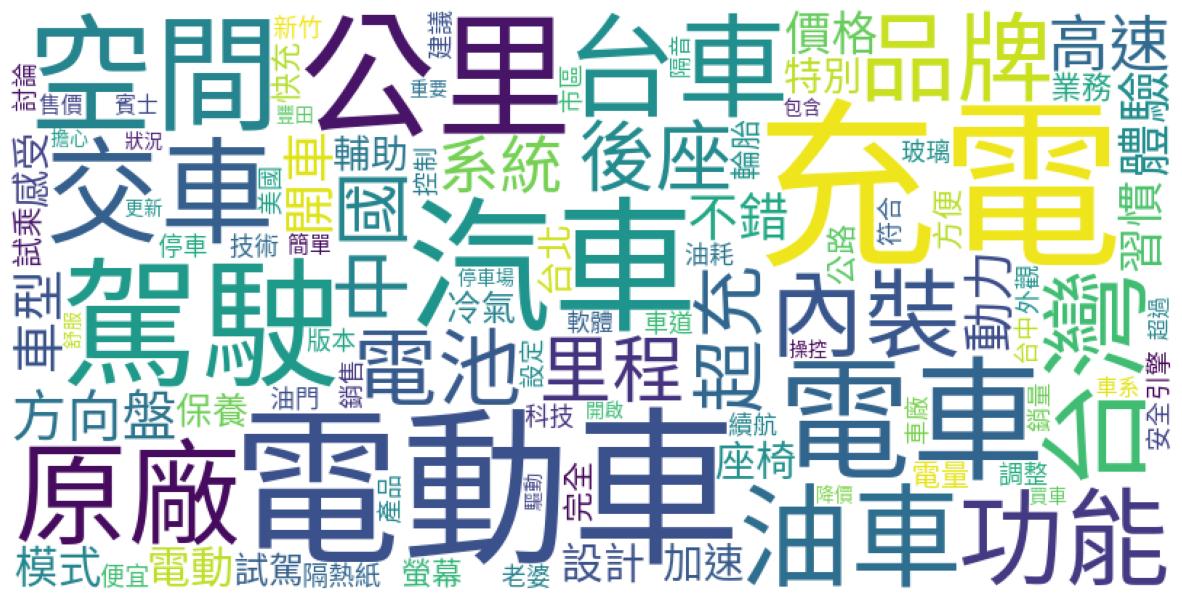

In [105]:
# 繪製文字雲
freq_experience_pos = get_freq_to_wordcloud(df_experience_pos)
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words =100)
wordcloud_nostop.generate_from_frequencies(freq_experience_pos)

plt.figure(figsize = (15,12))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

### 負面文字雲

Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt ...
2024-06-06 18:35:27,067 : DEBUG : Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt ...
Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.ub420de3365ed380a966939938bdca42e.cache
2024-06-06 18:35:27,069 : DEBUG : Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.ub420de3365ed380a966939938bdca42e.cache
Loading model cost 0.237 seconds.
2024-06-06 18:35:27,306 : DEBUG : Loading model cost 0.237 seconds.
Prefix dict has been built successfully.
2024-06-06 18:35:27,306 : DEBUG : Prefix dict has been built successfully.


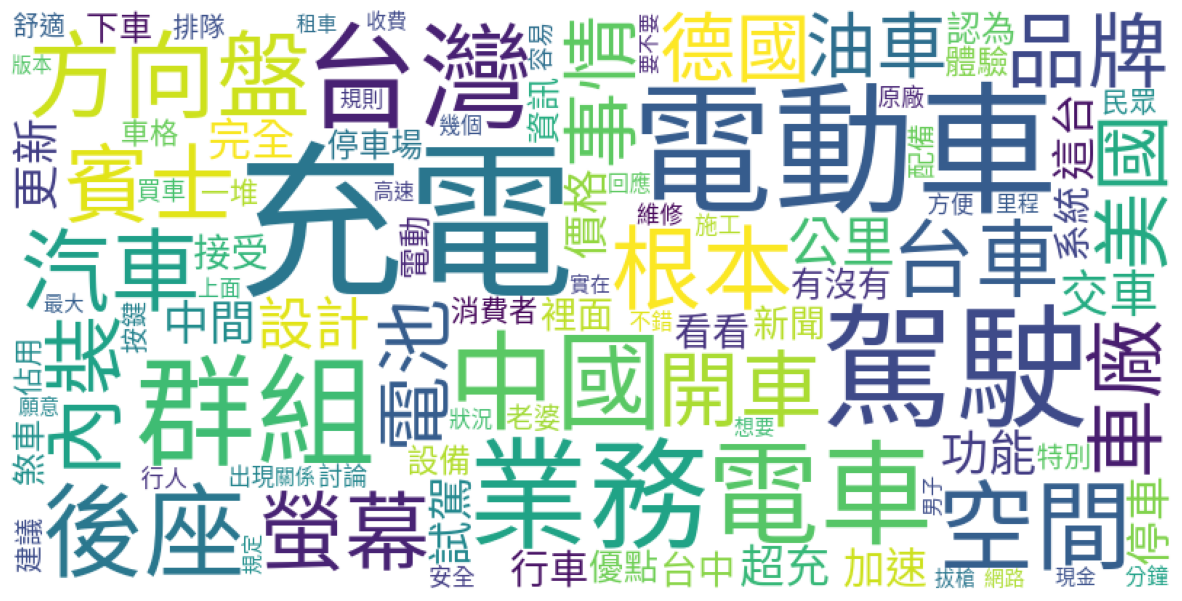

In [106]:
# 繪製文字雲
freq_experience_pos = get_freq_to_wordcloud(df_experience_neg)
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words =100)
wordcloud_nostop.generate_from_frequencies(freq_experience_pos)

plt.figure(figsize = (15,12))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

### Bigram

In [27]:
df_experience['artContent'] = df_experience['artContent'].astype(str)
# 只留下中文字
df_experience['sentence'] = df_experience['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

df_experience.head(5)

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗
3,3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"{""文章分類"":""使用者體驗"",""情緒"":""負面"",}",負面,使用者體驗
20,20,2023-01-07 16:47:05,問題特斯拉扯著是不是比較少改車啊,路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...,路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面"",}",負面,使用者體驗
24,24,2023-01-10 16:54:06,問題怎麼調適買錯車的心情,人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...,人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面""}",負面,使用者體驗
25,25,2023-01-11 18:27:00,討論不看看外型就知道的品牌,對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...,對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面"",}",負面,使用者體驗


In [43]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [44]:
exper_bigram = df_experience.copy()

exper_bigram["word"] = exper_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
exper_bigram = exper_bigram.explode('word')

exper_bigram.head(3)

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class,word
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗,王家 徐兆緯
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗,徐兆緯 台北
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗,台北 前電


In [45]:
# 計算每個組合出現的次數
exper_bigram_count = exper_bigram['word'].value_counts().reset_index()

# 重命名列
exper_bigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
exper_bigram_count_sorted = exper_bigram_count.sort_values('count', ascending=False).head(20)

print(exper_bigram_count_sorted)

       word  count
0     輔助 駕駛     39
2   意見 標點符號     24
1     網址 意見     24
3    汽車 製造商     19
4     續航 里程     16
5     充電 充電     15
6    電動車 市場     15
7     里程 公里     15
8     充電 設備     14
9     後輪 驅動     14
10    駕駛 輔助     13
11    符合 需求     13
13    里程 焦慮     12
14    露營 模式     12
12    彩色 電子     12
15    集團 集團     11
16    駕駛 體驗     10
17    動能 回收     10
18   中國 電動車     10
19    開車 開車      9


In [46]:
exper_trigram = df_experience.copy()

exper_trigram["word"] = exper_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
exper_trigram = exper_trigram.explode('word')

exper_trigram.head(3)

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class,word
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗,王家 徐兆緯 台北
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗,徐兆緯 台北 前電
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗,台北 前電 世界冠軍


Trigram

In [47]:
# 計算每個組合出現的次數
exper_trigram_count = exper_trigram['word'].value_counts().reset_index()

# 重命名列
exper_trigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
exper_trigram_count_sorted = exper_trigram_count.sort_values('count', ascending=False).head(20)

print(exper_trigram_count_sorted)

          word  count
0   網址 意見 標點符號     24
2     集團 集團 集團      7
1     駕駛 輔助 系統      7
3    車馬費 民國 年次      6
4   座談會 車馬費 民國      6
5     開車 開車 輔助      6
10    公里 消耗 電量      5
13   公里 電耗 每度電      5
12   每度電 里程 公里      5
11    電量 公里 電耗      5
9     消耗 電量 公里      5
8   百周年 紀念 概念車      5
7     里程 公里 消耗      5
6    電耗 每度電 里程      5
24   中國 汽車 製造商      4
33    熱烈 鄉民 開來      4
32    一半 緩速 前進      4
30    輔助 駕駛 系統      4
29    新版 後輪 驅動      4
28    討論 熱烈 鄉民      4


In [49]:
bigramudist = df_experience.copy()

bigramudist["word"] = bigramudist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramudist = bigramudist.explode('word')
bigramudist.dropna(subset = ['word'], axis=0, how='any', inplace=True)
bigramudist.head(3)


,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class,word
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗,王家 徐兆緯
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗,徐兆緯 台北
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗,台北 前電


In [50]:
# 計算每個組合出現的次數
exper_bigram_count = exper_bigram['word'].value_counts().reset_index()

# 重命名列
exper_bigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
exper_bigram_count_sorted = exper_bigram_count.sort_values('count', ascending=False).head(20)

print(exper_bigram_count_sorted)

       word  count
0     輔助 駕駛     39
2   意見 標點符號     24
1     網址 意見     24
3    汽車 製造商     19
4     續航 里程     16
5     充電 充電     15
6    電動車 市場     15
7     里程 公里     15
8     充電 設備     14
9     後輪 驅動     14
10    駕駛 輔助     13
11    符合 需求     13
13    里程 焦慮     12
14    露營 模式     12
12    彩色 電子     12
15    集團 集團     11
16    駕駛 體驗     10
17    動能 回收     10
18   中國 電動車     10
19    開車 開車      9


In [51]:
bigramudist['word'] = bigramudist['word'].astype(str)
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramudist = FreqDist(bigramudist['word'].apply(lambda x: tuple(x.split(' '))))
bigramudist.most_common(5)

[(('輔助', '駕駛'), 39),
 (('網址', '意見'), 24),
 (('意見', '標點符號'), 24),
 (('汽車', '製造商'), 19),
 (('續航', '里程'), 16)]

In [52]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramudist.most_common(50)}
d.items()

dict_items([(('輔助', '駕駛'), 39), (('網址', '意見'), 24), (('意見', '標點符號'), 24), (('汽車', '製造商'), 19), (('續航', '里程'), 16), (('里程', '公里'), 15), (('電動車', '市場'), 15), (('充電', '充電'), 15), (('充電', '設備'), 14), (('後輪', '驅動'), 14), (('符合', '需求'), 13), (('駕駛', '輔助'), 13), (('里程', '焦慮'), 12), (('露營', '模式'), 12), (('彩色', '電子'), 12), (('集團', '集團'), 11), (('中國', '電動車'), 10), (('駕駛', '體驗'), 10), (('動能', '回收'), 10), (('開車', '開車'), 9), (('充電', '車格'), 9), (('公有', '停車場'), 9), (('油車', '電車'), 9), (('行車', '記錄器'), 9), (('輔助', '系統'), 9), (('活動', '網頁'), 9), (('後座', '空間'), 8), (('電動車', '銷量'), 8), (('公里', '電耗'), 8), (('家裡', '充電'), 8), (('預約', '試駕'), 8), (('中間', '螢幕'), 8), (('後座', '中間'), 8), (('中央', '扶手'), 7), (('充電', '結束'), 7), (('佔用', '充電'), 7), (('完整', '新聞'), 7), (('氣壓', '懸吊'), 7), (('全景', '天窗'), 7), (('迴轉', '半徑'), 7), (('通風', '座椅'), 7), (('中國', '品牌'), 7), (('小鵬', '汽車'), 7), (('消耗', '電量'), 7), (('內裝', '質感'), 7), (('哨兵', '模式'), 7), (('雙層', '玻璃'), 7), (('充電', '麻煩'), 6), (('公升', '公里'), 6), (('豪華', '品牌'), 6)])

In [53]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    print(k[0])
    print(v)
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得edge權重
weights = [w[2]['weight']*0.001 for w in  G.edges(data=True)]

輔助
39
網址
24
意見
24
汽車
19
續航
16
里程
15
電動車
15
充電
15
充電
14
後輪
14
符合
13
駕駛
13
里程
12
露營
12
彩色
12
集團
11
中國
10
駕駛
10
動能
10
開車
9
充電
9
公有
9
油車
9
行車
9
輔助
9
活動
9
後座
8
電動車
8
公里
8
家裡
8
預約
8
中間
8
後座
8
中央
7
充電
7
佔用
7
完整
7
氣壓
7
全景
7
迴轉
7
通風
7
中國
7
小鵬
7
消耗
7
內裝
7
哨兵
7
雙層
7
充電
6
公升
6
豪華
6


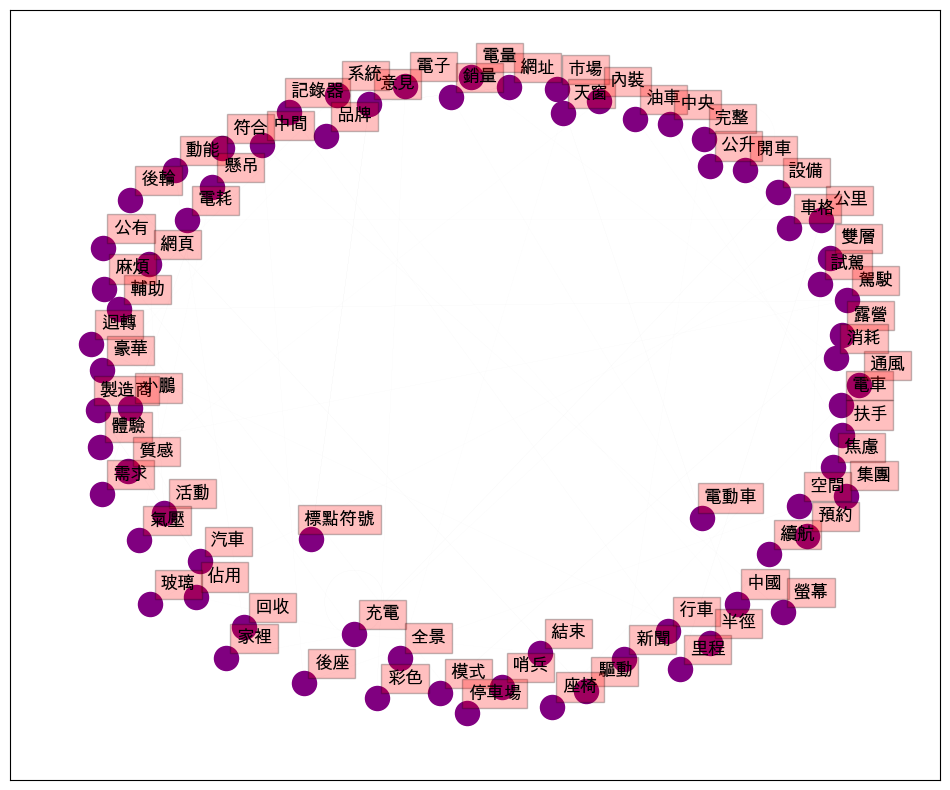

In [54]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=4)# k越大，斥力越小l;k越小，斥力越大

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
plt.show()

## 服務方面深入分析

In [2]:
df = pd.read_csv("data/ppt_tesla_classified_cleaned.csv")
df_service = df[df["class"]== "使用者體驗"]
df_service_pos =df_service[df_service['sentiment']=='正面']
df_service_neg =df_service[df_service['sentiment']=='負面']
df_service

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗
3,3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"{""文章分類"":""使用者體驗"",""情緒"":""負面"",}",負面,使用者體驗
20,20,2023-01-07 16:47:05,問題特斯拉扯著是不是比較少改車啊,路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...,路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面"",}",負面,使用者體驗
24,24,2023-01-10 16:54:06,問題怎麼調適買錯車的心情,人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...,人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面""}",負面,使用者體驗
25,25,2023-01-11 18:27:00,討論不看看外型就知道的品牌,對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...,對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面"",}",負面,使用者體驗
...,...,...,...,...,...,...,...,...
1569,1569,2024-04-26 22:02:33,新聞突破中國低價競爭特斯拉正走入重新調,補充一些資訊福斯集團已經宣布使用華為的智能駕駛方案簽約小鵬汽車電動平台讓比亞迪後現在電池電機...,補充一些資訊福斯集團已經宣布使用華為的智能駕駛方案簽約小鵬汽車電動平台讓比亞迪後現在電池電機...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面""}",負面,使用者體驗
1571,1571,2024-04-28 02:40:00,電車特斯拉改款後座有螢幕萬,昨天去試乘順便看改款的業務有傳簡訊不過新版沒有試乘車第一次開他的方向盤很簡潔我喜歡現在的車做...,昨天去試乘順便看改款的業務有傳簡訊不過新版沒有試乘車第一次開他的方向盤很簡潔我喜歡現在的車做...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""正面""}",正面,使用者體驗
1575,1575,2024-04-29 12:31:50,心得特斯拉煥新版試駕心得,完整圖文這次試駕的是全輪驅動版有選配烈焰紅車漆吋輪圈輪胎尺寸搭配的原廠胎是馬牌靜音型輪胎車尾...,完整圖文這次試駕的是全輪驅動版有選配烈焰紅車漆吋輪圈輪胎尺寸搭配的原廠胎是馬牌靜音型輪胎車尾...,"{""文章分類"": ""使用者體驗"",""情緒"": ""正面"",""內容"": ""煥新版方向盤握感比舊款...",正面,使用者體驗
1576,1576,2024-04-29 17:57:25,電車拖吊時哨兵模式運作,剛看到一台被拖吊大燈在那邊閃這個情況的哨兵模式是會持續地一直運作像是直播那樣還是周期性的一直...,剛看到一台被拖吊大燈在那邊閃這個情況的哨兵模式是會持續地一直運作像是直播那樣還是周期性的一直...,"{""文章分類"":""使用者體驗"",""情緒"":""負面"",}",負面,使用者體驗


In [3]:
df_service_neg

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗
3,3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"{""文章分類"":""使用者體驗"",""情緒"":""負面"",}",負面,使用者體驗
20,20,2023-01-07 16:47:05,問題特斯拉扯著是不是比較少改車啊,路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...,路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面"",}",負面,使用者體驗
24,24,2023-01-10 16:54:06,問題怎麼調適買錯車的心情,人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...,人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面""}",負面,使用者體驗
25,25,2023-01-11 18:27:00,討論不看看外型就知道的品牌,對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...,對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面"",}",負面,使用者體驗
...,...,...,...,...,...,...,...,...
1534,1534,2024-04-20 21:55:03,討論二手兩百多萬舒適省油空間大的轎車,如題去年二月買了空間大的沒話說但舒適性油耗就差強人意原先預計一年大概三萬公里油耗每公升公里還...,如題去年二月買了空間大的沒話說但舒適性油耗就差強人意原先預計一年大概三萬公里油耗每公升公里還...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面"",""內容"": ""空間大但舒適性油耗差，...",負面,使用者體驗
1542,1542,2024-04-22 11:14:13,問題特斯拉業務很急,之前聽別人說特斯拉業務不是很在乎業績因為都是在網路上付下訂為什麼我遇到的業務很急看個煥新版一...,之前聽別人說特斯拉業務不是很在乎業績因為都是在網路上付下訂為什麼我遇到的業務很急看個煥新版一...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面""}",負面,使用者體驗
1559,1559,2024-04-26 09:08:39,電車台灣特斯拉降價,特斯拉出現錯誤台灣版誤植趕快爆買特斯拉現買現賺萬大家可以看看是網頁錯誤還是整個都錯誤,特斯拉出現錯誤台灣版誤植趕快爆買特斯拉現買現賺萬大家可以看看是網頁錯誤還是整個都錯誤,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面""}",負面,使用者體驗
1569,1569,2024-04-26 22:02:33,新聞突破中國低價競爭特斯拉正走入重新調,補充一些資訊福斯集團已經宣布使用華為的智能駕駛方案簽約小鵬汽車電動平台讓比亞迪後現在電池電機...,補充一些資訊福斯集團已經宣布使用華為的智能駕駛方案簽約小鵬汽車電動平台讓比亞迪後現在電池電機...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面""}",負面,使用者體驗


In [4]:
def get_freq_to_wordcloud(input_df):
    jieba.set_dictionary("dict/dict.txt")
    df_service_pos＿word = input_df.assign(word = input_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)
    df_service_pos＿word = df_service_pos＿word.loc[df_service_pos＿word['word'].str.len() > 1]
    stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 
    after_clear_df_pos = df_service_pos＿word[~df_service_pos＿word['word'].isin(stopwords)]
    freq_df_clear_pos = pd.DataFrame(pd.value_counts(after_clear_df_pos['word'])).sort_values(by = ['count'], ascending = False).reset_index()
    freq_dict_nostop_pos = freq_df_clear_pos.set_index('word').to_dict()
    freq_dict_nostop_pos = freq_dict_nostop_pos['count']
    return freq_dict_nostop_pos


### 正面文字雲

Building prefix dict from /Users/aiden/我的雲端硬碟/中山大學資管所/112-2 MIS581 社群媒體分析/SMA_project/dict/dict.txt ...
Loading model from cache /var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/jieba.uf992522de474b4d252da611e5422339f.cache
Loading model cost 0.276 seconds.
Prefix dict has been built successfully.


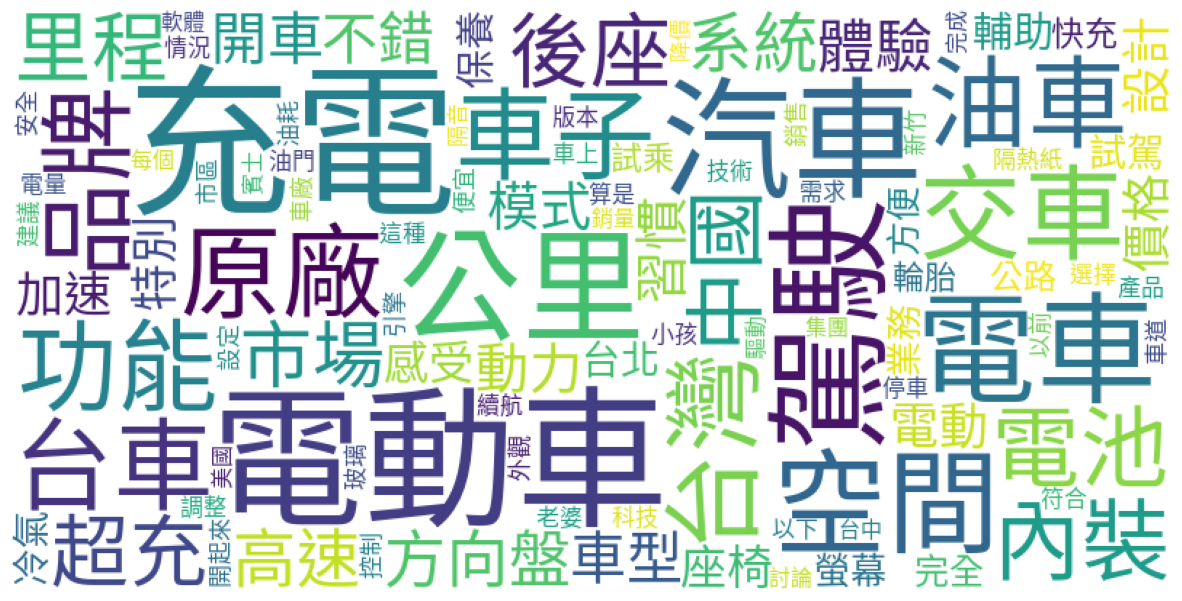

In [8]:
# 繪製文字雲
freq_service_pos = get_freq_to_wordcloud(df_service_pos)
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words =100)
wordcloud_nostop.generate_from_frequencies(freq_service_pos)

plt.figure(figsize = (15,12))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

### 負面文字雲

Building prefix dict from /Users/aiden/我的雲端硬碟/中山大學資管所/112-2 MIS581 社群媒體分析/SMA_project/dict/dict.txt ...
Loading model from cache /var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/jieba.uf992522de474b4d252da611e5422339f.cache
Loading model cost 0.256 seconds.
Prefix dict has been built successfully.


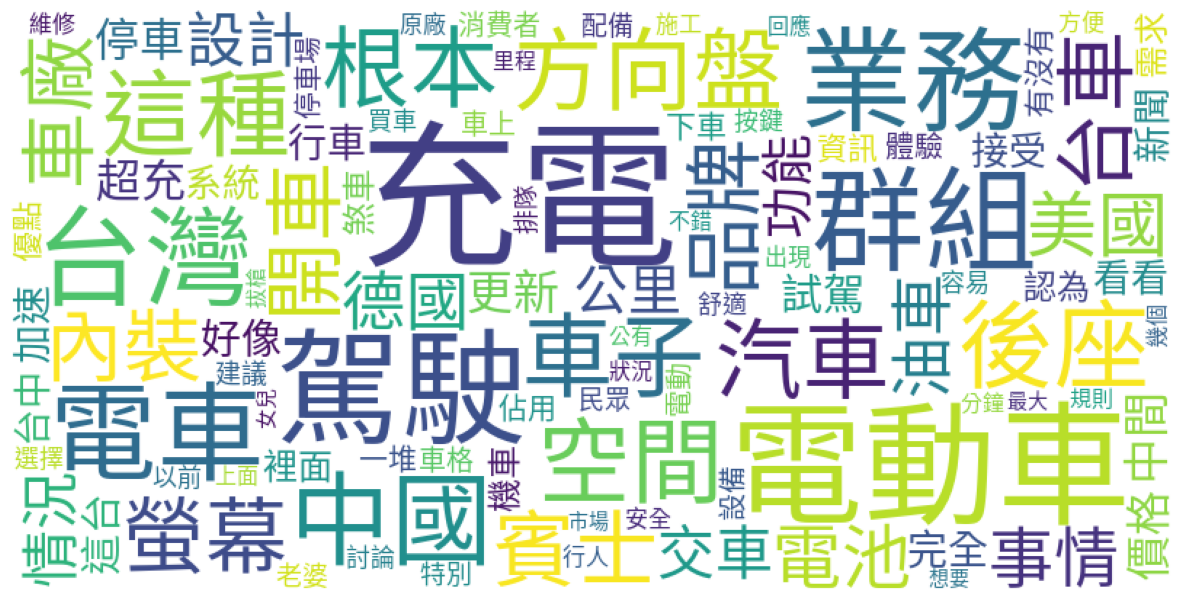

In [9]:
# 繪製文字雲
freq_service_pos = get_freq_to_wordcloud(df_service_neg)
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words =100)
wordcloud_nostop.generate_from_frequencies(freq_service_pos)

plt.figure(figsize = (15,12))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

### Bigram

In [10]:
df_service['artContent'] = df_service['artContent'].astype(str)
# 只留下中文字
df_service['sentence'] = df_service['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

df_service.head(5)

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗
3,3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"{""文章分類"":""使用者體驗"",""情緒"":""負面"",}",負面,使用者體驗
20,20,2023-01-07 16:47:05,問題特斯拉扯著是不是比較少改車啊,路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...,路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面"",}",負面,使用者體驗
24,24,2023-01-10 16:54:06,問題怎麼調適買錯車的心情,人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...,人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面""}",負面,使用者體驗
25,25,2023-01-11 18:27:00,討論不看看外型就知道的品牌,對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...,對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面"",}",負面,使用者體驗


In [11]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [17]:
exper_bigram = df_service.copy()

exper_bigram["word"] = exper_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
exper_bigram = exper_bigram.explode('word')

exper_bigram.head(3)

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class,word
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗,王家 徐兆緯
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗,徐兆緯 台北
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗,台北 前電


In [18]:
# 計算每個組合出現的次數
exper_bigram_count = exper_bigram['word'].value_counts().reset_index()

# 重命名列
exper_bigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
exper_bigram_count_sorted = exper_bigram_count.sort_values('count', ascending=False).head(20)

print(exper_bigram_count_sorted)

       word  count
0     輔助 駕駛     39
2   意見 標點符號     24
1     網址 意見     24
3    汽車 製造商     19
4     續航 里程     16
5     充電 充電     15
6    電動車 市場     15
7     里程 公里     15
8     充電 設備     14
9     後輪 驅動     14
10    駕駛 輔助     13
11    符合 需求     13
13    里程 焦慮     12
14    露營 模式     12
12    彩色 電子     12
15    集團 集團     11
16    駕駛 體驗     10
17    動能 回收     10
18   中國 電動車     10
19    開車 開車      9


In [20]:
exper_trigram = df_service.copy()

exper_trigram["word"] = exper_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
exper_trigram = exper_trigram.explode('word')

exper_trigram.head(3)

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class,word
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗,王家 徐兆緯 台北
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗,徐兆緯 台北 前電
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗,台北 前電 世界冠軍


Trigram

In [21]:
# 計算每個組合出現的次數
exper_trigram_count = exper_trigram['word'].value_counts().reset_index()

# 重命名列
exper_trigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
exper_trigram_count_sorted = exper_trigram_count.sort_values('count', ascending=False).head(20)

print(exper_trigram_count_sorted)

          word  count
0   網址 意見 標點符號     24
2     集團 集團 集團      7
1     駕駛 輔助 系統      7
3    車馬費 民國 年次      6
4   座談會 車馬費 民國      6
5     開車 開車 輔助      6
10    公里 消耗 電量      5
13   公里 電耗 每度電      5
12   每度電 里程 公里      5
11    電量 公里 電耗      5
9     消耗 電量 公里      5
8   百周年 紀念 概念車      5
7     里程 公里 消耗      5
6    電耗 每度電 里程      5
24   中國 汽車 製造商      4
33    熱烈 鄉民 開來      4
32    一半 緩速 前進      4
30    輔助 駕駛 系統      4
29    新版 後輪 驅動      4
28    討論 熱烈 鄉民      4


In [23]:
bigramudist = df_service.copy()

bigramudist["word"] = bigramudist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramudist = bigramudist.explode('word')
bigramudist.dropna(subset = ['word'], axis=0, how='any', inplace=True)
bigramudist.head(3)


,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class,word
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗,王家 徐兆緯
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗,徐兆緯 台北
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗,台北 前電


In [24]:
# 計算每個組合出現的次數
exper_bigram_count = exper_bigram['word'].value_counts().reset_index()

# 重命名列
exper_bigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
exper_bigram_count_sorted = exper_bigram_count.sort_values('count', ascending=False).head(20)

print(exper_bigram_count_sorted)

       word  count
0     輔助 駕駛     39
2   意見 標點符號     24
1     網址 意見     24
3    汽車 製造商     19
4     續航 里程     16
5     充電 充電     15
6    電動車 市場     15
7     里程 公里     15
8     充電 設備     14
9     後輪 驅動     14
10    駕駛 輔助     13
11    符合 需求     13
13    里程 焦慮     12
14    露營 模式     12
12    彩色 電子     12
15    集團 集團     11
16    駕駛 體驗     10
17    動能 回收     10
18   中國 電動車     10
19    開車 開車      9


In [25]:
bigramudist['word'] = bigramudist['word'].astype(str)
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramudist = FreqDist(bigramudist['word'].apply(lambda x: tuple(x.split(' '))))
bigramudist.most_common(5)

[(('輔助', '駕駛'), 39),
 (('網址', '意見'), 24),
 (('意見', '標點符號'), 24),
 (('汽車', '製造商'), 19),
 (('續航', '里程'), 16)]

In [26]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramudist.most_common(50)}
d.items()

dict_items([(('輔助', '駕駛'), 39), (('網址', '意見'), 24), (('意見', '標點符號'), 24), (('汽車', '製造商'), 19), (('續航', '里程'), 16), (('里程', '公里'), 15), (('電動車', '市場'), 15), (('充電', '充電'), 15), (('充電', '設備'), 14), (('後輪', '驅動'), 14), (('符合', '需求'), 13), (('駕駛', '輔助'), 13), (('里程', '焦慮'), 12), (('露營', '模式'), 12), (('彩色', '電子'), 12), (('集團', '集團'), 11), (('中國', '電動車'), 10), (('駕駛', '體驗'), 10), (('動能', '回收'), 10), (('開車', '開車'), 9), (('充電', '車格'), 9), (('公有', '停車場'), 9), (('油車', '電車'), 9), (('行車', '記錄器'), 9), (('輔助', '系統'), 9), (('活動', '網頁'), 9), (('後座', '空間'), 8), (('電動車', '銷量'), 8), (('公里', '電耗'), 8), (('家裡', '充電'), 8), (('預約', '試駕'), 8), (('中間', '螢幕'), 8), (('後座', '中間'), 8), (('中央', '扶手'), 7), (('充電', '結束'), 7), (('佔用', '充電'), 7), (('完整', '新聞'), 7), (('氣壓', '懸吊'), 7), (('全景', '天窗'), 7), (('迴轉', '半徑'), 7), (('通風', '座椅'), 7), (('中國', '品牌'), 7), (('小鵬', '汽車'), 7), (('消耗', '電量'), 7), (('內裝', '質感'), 7), (('哨兵', '模式'), 7), (('雙層', '玻璃'), 7), (('充電', '麻煩'), 6), (('公升', '公里'), 6), (('豪華', '品牌'), 6)])

In [27]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    print(k[0])
    print(v)
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得edge權重
weights = [w[2]['weight']*0.001 for w in  G.edges(data=True)]

輔助
39
網址
24
意見
24
汽車
19
續航
16
里程
15
電動車
15
充電
15
充電
14
後輪
14
符合
13
駕駛
13
里程
12
露營
12
彩色
12
集團
11
中國
10
駕駛
10
動能
10
開車
9
充電
9
公有
9
油車
9
行車
9
輔助
9
活動
9
後座
8
電動車
8
公里
8
家裡
8
預約
8
中間
8
後座
8
中央
7
充電
7
佔用
7
完整
7
氣壓
7
全景
7
迴轉
7
通風
7
中國
7
小鵬
7
消耗
7
內裝
7
哨兵
7
雙層
7
充電
6
公升
6
豪華
6


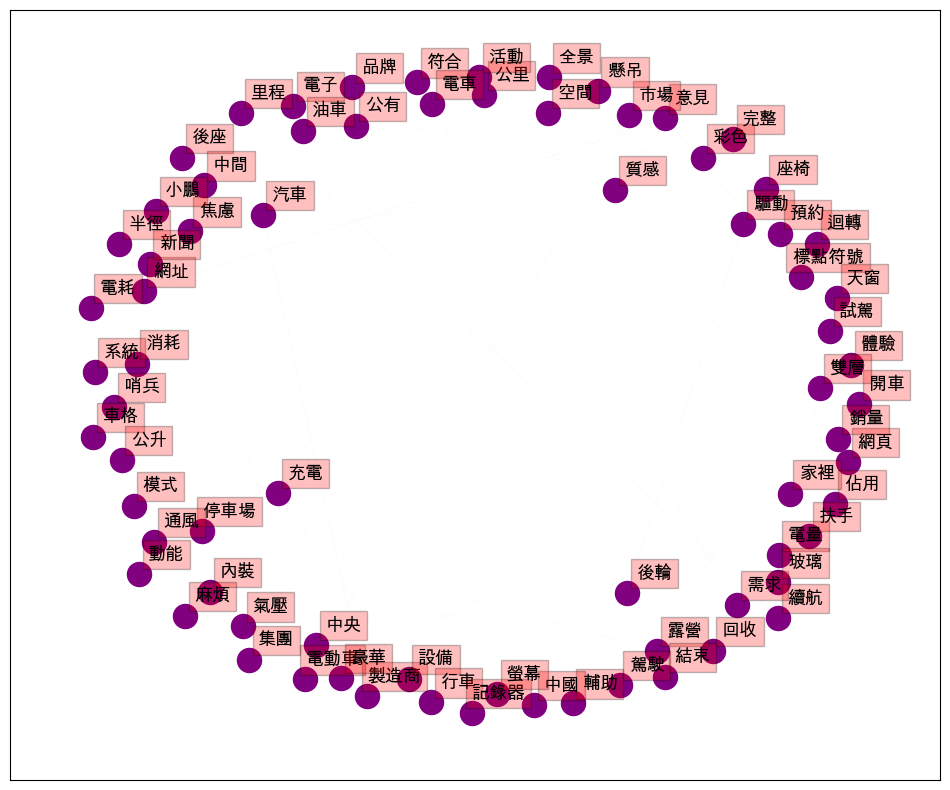

In [28]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=4)# k越大，斥力越小l;k越小，斥力越大

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
plt.show()